In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [190]:
import itertools
import math
import numpy as np
import numpy.fft as fft
import pandas as pd

from joblib import Parallel, delayed
from numba import njit
from scipy.stats import zscore
from tqdm import tqdm
from saxpy.znorm import znorm
from ast import literal_eval
from os.path import exists

from saxpy.znorm import znorm
from saxpy.paa import paa
from saxpy.alphabet import cuts_for_asize
from saxpy.sax import ts_to_string

slack = 0.6

file = 'C:\\Users\\jbzp18481526321\\datasets\\ground_truth\\winding_col.csv'
ts_csv= pd.read_csv(file, index_col=0)
ts_origin = ts_csv.values   #csv to numpy

paa_length = 4
paa_size = len(ts_origin)//paa_length
ts = ts_origin[0:(paa_size * paa_length)]            #截取需要实验的TS
ts = list(itertools.chain.from_iterable(ts))
paa_win_size = paa_length*40

def apply_sax(ts, paa_win_size, paa_length, alphabet_size):           #paa_length是原时间序列长度和新时间序列长度之比，即n/w       
    sax_sequence = []
    cuts = cuts_for_asize(alphabet_size)
    ts_znorm = znorm(ts, 0.01)              #z_threshold 取 0.01         #先将整个时间序列离散化
    for t in np.arange(0, len(ts) - paa_win_size + 1, paa_win_size):
        ts_win = znorm(ts[t:(t+paa_win_size)])          #取窗口
        paa_rep = paa(ts_win, 100)            #取平均值   
        sax_word = list(ts_to_string(paa_rep, cuts))   #离散化
        sax_sequence.append(sax_word)
        sax_sequence = list(itertools.chain.from_iterable(sax_sequence))
    return sax_sequence

In [191]:
(ts)

[0.7713147658847539,
 0.7410917121340006,
 0.7075515773560657,
 0.7282723070371097,
 0.6628992996316536,
 0.6878493973661594,
 0.7139209476885798,
 0.7219338345717651,
 0.6593795325955641,
 0.6726471967498466,
 0.7114034314687133,
 0.7122844706519823,
 0.6727254913452955,
 0.7162126594953651,
 0.7000394959030796,
 0.707511680110109,
 0.8425883259844587,
 0.8063334486008804,
 0.9214867297533534,
 0.893972309029978,
 0.8754602368888229,
 0.9012472968491598,
 0.9049542909612626,
 0.8686472471786477,
 1.1561531811021053,
 0.7209215344492297,
 0.2014882001046987,
 -0.3309478666819286,
 -0.7935040771636988,
 -1.201850349671116,
 -1.434060920545384,
 -1.543025598887249,
 -1.6459082970585146,
 -1.705044514979612,
 -1.9952441829589,
 -1.3264786467783338,
 -0.6711311743702049,
 -0.2467970054818017,
 0.1657652060060647,
 0.5102413073696331,
 0.6446885066936753,
 0.8077188729672439,
 0.8006897281779093,
 0.8228345595554821,
 1.0382200218401891,
 0.6531604818867259,
 0.1082452865144621,
 -0.4143863

In [192]:
sax_sequence = apply_sax(ts,400, 4, 13)
print(len(sax_sequence))
print(sax_sequence)

600
['j', 'j', 'j', 'j', 'k', 'k', 'i', 'b', 'a', 'f', 'j', 'i', 'b', 'a', 'a', 'b', 'b', 'b', 'b', 'g', 'j', 'k', 'k', 'j', 'k', 'k', 'h', 'b', 'a', 'g', 'j', 'i', 'b', 'a', 'b', 'b', 'f', 'j', 'k', 'l', 'k', 'h', 'a', 'a', 'f', 'j', 'h', 'c', 'a', 'f', 'i', 'k', 'k', 'l', 'k', 'k', 'i', 'b', 'a', 'g', 'i', 'k', 'l', 'k', 'k', 'j', 'j', 'j', 'i', 'j', 'k', 'j', 'j', 'j', 'd', 'b', 'b', 'b', 'b', 'b', 'b', 'd', 'i', 'k', 'l', 'l', 'k', 'j', 'j', 'c', 'a', 'c', 'i', 'j', 'k', 'k', 'k', 'k', 'k', 'j', 'k', 'i', 'c', 'b', 'i', 'l', 'j', 'd', 'c', 'j', 'l', 'k', 'c', 'b', 'h', 'k', 'i', 'c', 'c', 'j', 'l', 'l', 'l', 'l', 'l', 'l', 'm', 'l', 'l', 'f', 'c', 'c', 'b', 'b', 'i', 'k', 'j', 'd', 'c', 'h', 'l', 'j', 'c', 'b', 'i', 'l', 'j', 'b', 'a', 'h', 'l', 'l', 'l', 'l', 'g', 'd', 'd', 'b', 'b', 'c', 'c', 'b', 'b', 'b', 'i', 'l', 'l', 'm', 'l', 'g', 'c', 'f', 'k', 'l', 'f', 'c', 'b', 'b', 'c', 'j', 'l', 'k', 'e', 'c', 'c', 'c', 'c', 'c', 'c', 'd', 'c', 'c', 'b', 'b', 'b', 'b', 'f', 'k', 'l', 

In [193]:
def extract_modified_bs_sequence(sax_sequence):
    
    bs_sequence = []
    bs_lengths = []
    curr_len = paa_length
    for i in range(len(sax_sequence)):
        curr_bs = sax_sequence[i]
        if i < len(sax_sequence)-1:
            next_bs = sax_sequence[i+1]
        else:
            next_bs = ''
        if curr_bs == next_bs:
            curr_len = curr_len + paa_length      #
        else:
            bs_sequence.append(curr_bs)  #直到出现第一次不相等的情形，将相邻的sax symbol合并
            bs_lengths.append(curr_len)
            curr_len = paa_length
    return bs_sequence, bs_lengths


#上述得到的bs_lengths并不是指针，为此我们用下面的函数
def generate_bs_pointers(bs_lengths):
    bs_pointers = []
    start_pointer = 0
    for bs_len_item in bs_lengths:
        end_pointer = start_pointer + bs_len_item       #bs_len_item是一个bs连续重复出现的次数 
        pointer_list = list(range(start_pointer, end_pointer))       #方便后续索引，motif的长度变成了window的长度加上bs_len_item的
        bs_pointers.append(pointer_list)                             #得到列表的列表
        start_pointer = start_pointer + bs_len_item
    return bs_pointers 

In [194]:
bs_sequence, bs_lengths = extract_modified_bs_sequence(sax_sequence)
bs_pointer = generate_bs_pointers(bs_lengths)    #

In [195]:
print(np.arange(0, len(ts) - paa_win_size + 1, paa_win_size))

[   0  160  320  480  640  800  960 1120 1280 1440 1600 1760 1920 2080
 2240]


In [196]:
print(len(bs_pointer))
print(bs_pointer)

418
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [16, 17, 18, 19, 20, 21, 22, 23], [24, 25, 26, 27], [28, 29, 30, 31], [32, 33, 34, 35], [36, 37, 38, 39], [40, 41, 42, 43], [44, 45, 46, 47], [48, 49, 50, 51], [52, 53, 54, 55, 56, 57, 58, 59], [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75], [76, 77, 78, 79], [80, 81, 82, 83], [84, 85, 86, 87, 88, 89, 90, 91], [92, 93, 94, 95], [96, 97, 98, 99, 100, 101, 102, 103], [104, 105, 106, 107], [108, 109, 110, 111], [112, 113, 114, 115], [116, 117, 118, 119], [120, 121, 122, 123], [124, 125, 126, 127], [128, 129, 130, 131], [132, 133, 134, 135], [136, 137, 138, 139, 140, 141, 142, 143], [144, 145, 146, 147], [148, 149, 150, 151], [152, 153, 154, 155], [156, 157, 158, 159], [160, 161, 162, 163], [164, 165, 166, 167], [168, 169, 170, 171, 172, 173, 174, 175], [176, 177, 178, 179], [180, 181, 182, 183], [184, 185, 186, 187], [188, 189, 190, 191], [192, 193, 194, 195], [196, 197, 198, 199], [200, 201, 202, 203], [204, 2

In [197]:
print(len(bs_sequence))
print(bs_sequence)

418
['j', 'k', 'i', 'b', 'a', 'f', 'j', 'i', 'b', 'a', 'b', 'g', 'j', 'k', 'j', 'k', 'h', 'b', 'a', 'g', 'j', 'i', 'b', 'a', 'b', 'f', 'j', 'k', 'l', 'k', 'h', 'a', 'f', 'j', 'h', 'c', 'a', 'f', 'i', 'k', 'l', 'k', 'i', 'b', 'a', 'g', 'i', 'k', 'l', 'k', 'j', 'i', 'j', 'k', 'j', 'd', 'b', 'd', 'i', 'k', 'l', 'k', 'j', 'c', 'a', 'c', 'i', 'j', 'k', 'j', 'k', 'i', 'c', 'b', 'i', 'l', 'j', 'd', 'c', 'j', 'l', 'k', 'c', 'b', 'h', 'k', 'i', 'c', 'j', 'l', 'm', 'l', 'f', 'c', 'b', 'i', 'k', 'j', 'd', 'c', 'h', 'l', 'j', 'c', 'b', 'i', 'l', 'j', 'b', 'a', 'h', 'l', 'g', 'd', 'b', 'c', 'b', 'i', 'l', 'm', 'l', 'g', 'c', 'f', 'k', 'l', 'f', 'c', 'b', 'c', 'j', 'l', 'k', 'e', 'c', 'd', 'c', 'b', 'f', 'k', 'l', 'm', 'l', 'b', 'k', 'j', 'g', 'a', 'e', 'j', 'k', 'j', 'd', 'a', 'b', 'i', 'j', 'k', 'j', 'e', 'b', 'd', 'i', 'j', 'd', 'b', 'c', 'i', 'k', 'j', 'd', 'b', 'd', 'j', 'k', 'j', 'k', 'i', 'b', 'a', 'g', 'j', 'h', 'b', 'a', 'b', 'c', 'b', 'h', 'k', 'j', 'k', 'h', 'b', 'a', 'g', 'j', 'h', 'b', 

In [198]:
def find_patetrn_location(bs_sequence,bs_pointer, win_size):
    pattern_list = []
    for i in range(len(bs_sequence)-win_size+1):
        saxpattern=[]
        sax_win = bs_sequence[i:i+win_size]
        for j in range(len(bs_sequence)-win_size+1):
            cur_word = bs_sequence[j:j+win_size]
            if sax_win == cur_word:
                cur_word_location = list(itertools.chain.from_iterable(bs_pointer[j:j+win_size]))
                saxpattern.append(cur_word_location)
        if len(saxpattern) > 1:
             pattern_list.append(saxpattern)
    return pattern_list                                         

In [203]:

win_size = 19
pattern_list = []
patterns = []
for i in range(len(bs_sequence)-win_size+1):
    saxpattern=[]
    sax_win = bs_sequence[i:i+win_size]
    for j in range(len(bs_sequence)-win_size+1):
        pattern = []
        cur_word = bs_sequence[j:j+win_size]
        if sax_win == cur_word:
            cur_word_location = list(itertools.chain.from_iterable(bs_pointer[j:j+win_size]))                                    
            saxpattern.append(cur_word_location)
            pattern.append(cur_word)
    if len(saxpattern) > 1:
            pattern_list.append(saxpattern)
            print(pattern)

[]
[]
[]
[]


In [204]:
print(pattern_list)
len(pattern_list)

[[[196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299], [1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242, 1243, 1244, 1245, 1246, 1247, 1248, 1249, 1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258, 1259, 1260, 1261, 1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1

4

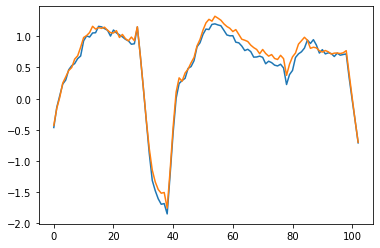

In [205]:
import matplotlib.pyplot as plt
plt.plot(ts[196:299])
plt.plot(ts[1196:1299])